# Multi-Layer Perceptron (MLP) 

The problem description and dataset information are located in `data/fashion-mnist-readme.txt`. The dataset files are `/data/fashion-mnist_train.csv` and `/data/fashion-mnist_train.csv`. The Multilayer Perceptron will be used to predict the clothing class label of each image (the first column of the dataset), using the values from the other columns as inputs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, List, Tuple, Optional
from sklearn.metrics import confusion_matrix

plt.rc('font', **{'size' : 18})

## Data Processing

In [2]:
train_set = pd.read_csv('./data/fashion-mnist_train.csv').values
test_set = pd.read_csv('./data/fashion-mnist_test.csv').values

Processing involves separating the first element from each row as the label $y$. We will do the same thing for both the train set and the test set:

In [3]:
train_x: np.ndarray = train_set[:, 1:]  # All features, excluding the first column (label)
train_y: np.ndarray = train_set[:, 0]   # Only the first column, which is the label

test_x: np.ndarray = test_set[:, 1:]    # Same for the test set
test_y: np.ndarray = test_set[:, 0]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# Checking that the training set is separated into samples and labels:
assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)

# Same for the test set:
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


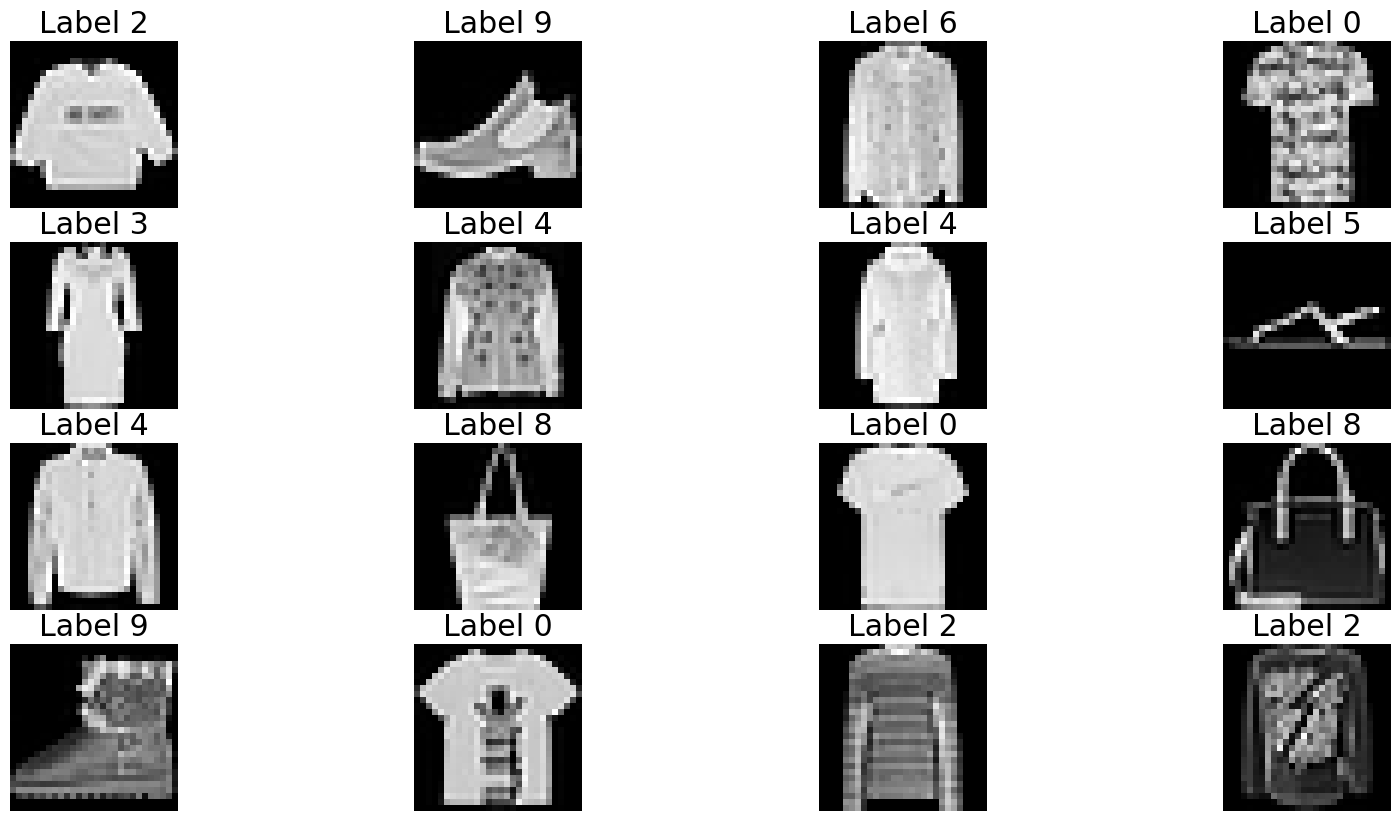

In [4]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Label {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16], train_y[:16])

In [5]:
def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means dividing by 255
    
    Args:
        x: the feature matrix, size m x n
    
    Returns:
        the matrix with scaled values in [0, 1], size m x n
    """
    return x / 255.0

In [6]:
train_x: np.ndarray = normalize(train_x)
test_x: np.ndarray = normalize(test_x)

assert np.all(np.logical_and(train_x >= 0., train_x <= 1.))
assert np.all(np.logical_and(test_x >= 0., test_x <= 1.))

Since we use the cross-entropy function for training, we will encode with 'one-hot encoding' the labels. The matrix train_y will transform from a matrix of size $(m, 1)$ to one of size $(m, k)$, where $k = 10$ (we have 10 classes).

In [7]:
def one_hot(set_y: np.ndarray, k: int) -> np.ndarray:
    """
    One-hot encoding converts an entire set into a matrix form.
    
    Args:
        set_y: Vector of size (m,), where 'm' represents the number of examples.
        k: Number of classes.
        
    Returns:
        Matrix of size (m, k), where each row represents the encoding of each label.
    """
    m = set_y.shape[0]
    result = np.zeros((m, k))
    set_y_int = set_y.astype(int)
    result[np.arange(m), set_y_int] = 1  
    return result

# Applying the one_hot function
train_y: np.ndarray = one_hot(train_y, 10)
test_y: np.ndarray = one_hot(test_y, 10)

print(train_y.shape)
print(test_y.shape)

# Checks
assert train_y.shape == (train_x.shape[0], 10)
assert test_y.shape == (test_y.shape[0], 10)
assert np.all(train_y.sum(axis=1) == 1)
assert np.all(test_y.sum(axis=1) == 1)

(60000, 10)
(10000, 10)


In the implementation of the activation function, we did not use the sigmoid function as before, but the hyperbolic tangent function. Here's what they look like:

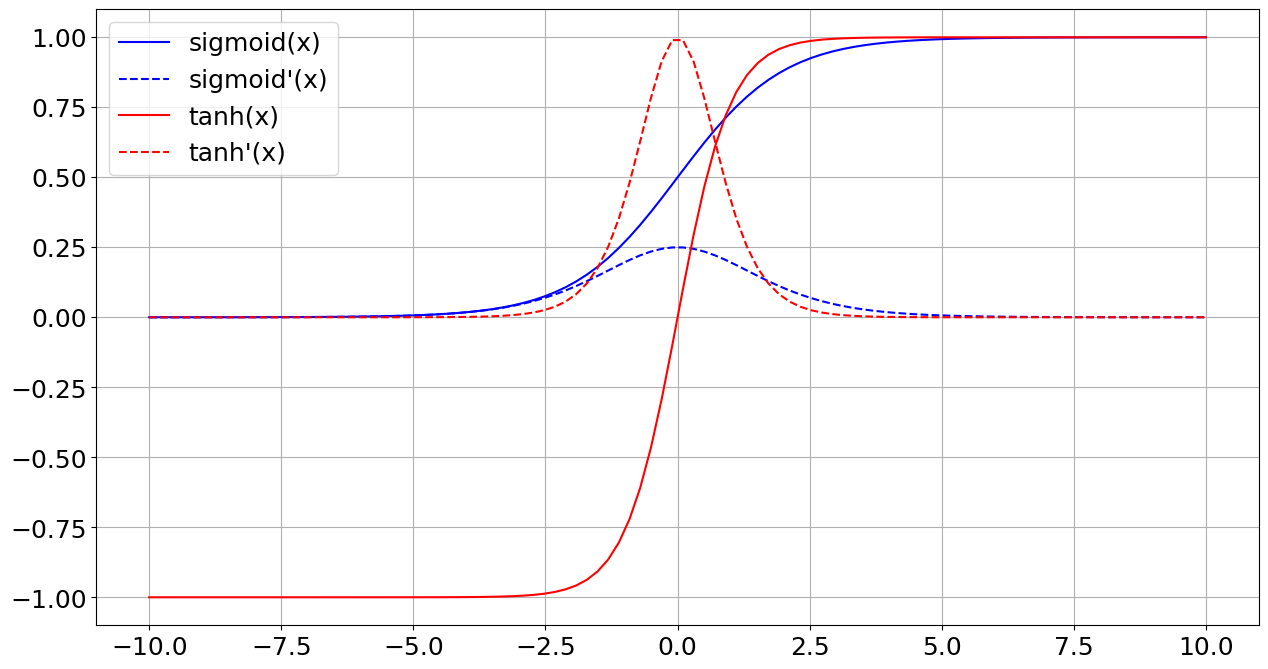

In [8]:
def represent():
    x = np.linspace(-10, 10, 100)
    sigmoid = lambda x: 1. / (1 + np.exp(-x))
    sigmoid_d = lambda x: sigmoid(x) * (1 - sigmoid(x))
    tanh = lambda x: np.tanh(x)
    tanh_d = lambda x: 1.0 - (tanh(x) ** 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.plot(x, sigmoid(x), '-', color='blue')
    ax.plot(x, sigmoid_d(x), '--', color='blue')
    ax.plot(x, tanh(x), '-', color='red')
    ax.plot(x, tanh_d(x), '--', color='red')
    ax.legend(['sigmoid(x)', "sigmoid'(x)", 'tanh(x)', "tanh'(x)"])
    ax.grid() ; plt.show()
    
represent()

We have the following remarks:
* the mean of the sigmoid function is 0.5, compared to 0.0 of tanh;
* the mean of the sigmoid derivative is 0.076 compared to 0.154 of the tanh derivative.

The hyperbolic tangent has a number of advantages:

* tanh is symmetric to 0. Applying it will still produce output values in this range (output values are inputs for the next layer);
* convergence is faster if all network activations have mean zero and variance 1, and are uncorrelated.

For a negative input, the output in the case of the sigmoid function saturates to 0. This does not happen in the case of the tanh() function, a negative input causes a negative activation. Through this behavior, the sigmoid function can cause the network to get stuck in local minima, making the learning process slower.

You can find more details in the article by [Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

## Implementation of the softmax function

In [9]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Calculates the activation function for a vector or matrix.
    
    Args:
        z: Vector or matrix of values.

    Returns:
        The vector or matrix after applying the sigmoid function.
    """
    return np.tanh(z)

def sigmoid_derivative(z: np.ndarray) -> np.ndarray:
    """
    Calculates the derivative values on the vector/matrix z.

    Args:
        z: Vector or matrix of values.
        
    Returns:
        The sigmoid function derivative for each element of z.
    """
    return 1.0 - (np.tanh(z) ** 2)

def softmax(z: np.ndarray) -> np.ndarray:
    """
    Calculates the softmax function on a matrix.

    Args:
        z: Matrix, where the number of columns equals the number of classes and 
           the number of rows is given by the minibatch size.
    
    Returns:
        A matrix where each row represents the application of the softmax function.
    """
    z_stable = z - np.max(z, axis=1, keepdims=True)
    z_exp = np.exp(z_stable)
    return z_exp / np.sum(z_exp, axis=1, keepdims=True)

# Testing the softmax function
a: np.ndarray = np.random.randn(100, 40) * 10000
assert a.shape == softmax(a).shape
assert np.all(softmax(a) >= 0)
assert np.allclose(softmax(a).sum(axis=1), 1)
assert softmax(a).sum(axis=1).shape == (a.shape[0],)
del a

## Implementation of forward propagation

The goal is to evaluate the entire network layer by layer, starting from the input. The activations of the first layer are the very samples of the data set $X$ (the minibatch).

The z's will be calculated for each layer:

$z = a \cdot w^T + b^T$, respectively the following activations:

$a = sigmoid(z)$, respectively the function $softmax()$ for the last layer.

For example, the entry $a_I$ has size $(m, I)$, m being the number of data in the minibatch. The weights of the first layer $w_{JI}$ have size $(J, I)$, so the activation $a_J = f(a_I \cdot w_{JI}^T + b_{JI}^T)$ will have size $(m , J)$ - we will use matrix multiplication for the calculation of $z_{J}$.

In [10]:
def forward(set_x: np.ndarray, 
            weights: List[np.ndarray], 
            biases: List[np.ndarray]) -> Tuple[List[np.ndarray], List[Optional[np.ndarray]]]:
    """
    Forward propagation through the network, calculating the nets and activations.
    
    Args:
        set_x: The input set of size (m, I).
        weights: The list of weight matrices.
        biases: The list of bias vectors.
        
    Returns:
        Tuple: (activations, nets) - where `activations` is a list of activations,
               and `nets` is a list of net inputs (z).
    """
    activations: List[np.ndarray] = [set_x]
    nets: List[Optional[np.ndarray]] = [None]

    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i].T) + biases[i]
        nets.append(z)
        if i == len(weights) - 1:  # Last layer
            activation = softmax(z)
        else:  # Other layers
            activation = sigmoid(z)
        activations.append(activation)

    return activations, nets

# Testing the forward function
inputs: np.ndarray = np.ones((3, 25)) * 0.5
weights: List[np.ndarray] = [np.ones((10, 25)) * 0.2, np.ones((4, 10)) * 0.3]
weights_backup: List[np.ndarray] = [item.copy() for item in weights]
biases: List[np.ndarray] = [np.ones(10) * 0.1, np.ones(4) * 0.1]
biases_backup: List[np.ndarray] = [item.copy() for item in biases]

activations, nets = forward(inputs, weights, biases)

# Checks
assert len(activations) == len(nets) == 3
assert activations[0].shape == inputs.shape == (3, 25)
assert activations[1].shape == (3, 10)
assert activations[2].shape == (3, 4)
assert nets[0] is None
assert nets[1].shape == (3, 10)
assert nets[2].shape == (3, 4)
assert all(np.all(w == w_bak) for w, w_bak in zip(weights, weights_backup))
assert all(np.all(b == b_bak) for b, b_bak in zip(biases, biases_backup))
del weights_backup, biases_backup

## Implementation of backward propagation

Backpropagation aims to calculate the gradient for each layer. For this, we will need to determine the associated $\delta$ for each layer starting from the last one.

Note that these $\delta$ are not column vectors, but matrices, with the first dimension the size of the batch and the second dimension the size of the layer. Based on $\delta$ you will determine the gradient, by averaging using the batch size (the first size).

A complication due to batch size occurs in the following relationship:

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

Here, $\delta_{a_K}$ has the size $(m, K)$ and by multiplying with $w_{KJ}$ a matrix of sizes $(m, J)$ is generated, the same as those of $f' (z_j)$.

A second complication also appears due to the batch size in the gradient calculation relations:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$

Here, $\delta_{a_J}$ has size $(m, J)$ and $a_I$, $(m, I)$. To multiply the first $m$ column vectors with the other $m$ line vectors, we use batch matrix multiplication - normal matrix multiplication only for the last two dimensions, for each element of dimension 0. That is, we resize $(m, J) \rightarrow ( m, J, 1)$ and $(m, I) \rightarrow (m, 1, I)$, and by their matrix multiplication we obtain $(m, J, I)$. We reduce by averaging the first dimension.

In [11]:
def backward(weights: List[np.ndarray], 
             biases: List[np.ndarray], 
             activations: List[np.ndarray], 
             nets: List[np.ndarray], 
             set_y: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Propagates delta back through the network starting from the last layer.
    
    Args:
        weights: The list of weights.
        biases: The list of biases.
        activations: The list of activations, calculated by forward.
        nets: The list of z values, calculated by forward.
        set_y: The labels, one-hot encoded.
        
    Returns:
        Tuple: (delta_w, delta_b) - where `delta_w` is a list of weight updates,
               and `delta_b` is a list of bias updates.
    """
    assert len(weights) == len(biases) 
    assert len(activations) == len(nets)
    assert nets[0] is None
    
    delta_b: List[np.ndarray] = [np.zeros_like(b) for b in biases]
    delta_w: List[np.ndarray] = [np.zeros_like(w) for w in weights]
    delta = activations[-1] - set_y

    delta_w[-1] = np.dot(delta.T, activations[-2]) / len(set_y)
    delta_b[-1] = np.mean(delta, axis=0)

    for l in range(2, len(weights) + 1):
        delta = np.dot(delta, weights[-l + 1]) * sigmoid_derivative(nets[-l])
        delta_w[-l] = np.dot(delta.T, activations[-l - 1]) / len(set_y)
        delta_b[-l] = np.mean(delta, axis=0)

    return delta_w, delta_b

# Testing the backward function
labels: np.ndarray = one_hot(np.array([1, 0, 3]), 4)
delta_w, delta_b = backward(weights, biases, activations, nets, labels)

# Checks
assert len(delta_w) == len(delta_b) == 2
assert delta_w[0].shape == (10, 25)
assert delta_w[1].shape == (4, 10)
assert delta_b[0].shape == (10,)
assert delta_b[1].shape == (4,)

## Calculation of a batch and accuracy

It consists of forward propagation, back propagation, followed by adjusting the weights.

In [12]:
def compute_batch(batch_x: np.ndarray, 
                  batch_y: np.ndarray, 
                  weights: List[np.ndarray], 
                  biases: List[np.ndarray], 
                  alpha: float, 
                  lmbda: float) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """ 
    Performs the two steps for each batch individually.
    
    Args:
        batch_x: The input samples.
        batch_y: Their labels.
        weights: The list of network weights.
        biases: The list of biases.
        alpha: The learning rate.
        lmbda: The regularization parameter.
        
    Returns:
        Tuple: (weights, biases) - the new weights and biases after updating them with the calculated gradients.
    """
    activations, nets = forward(batch_x, weights, biases)
    delta_w, delta_b = backward(weights, biases, activations, nets, batch_y)

    # Updating weights and biases
    for i in range(len(weights)):
        weights[i] = weights[i] - alpha * (delta_w[i] + lmbda * weights[i])
        biases[i] = biases[i] - alpha * delta_b[i]
    
    return weights, biases

Accuracy involves inspecting the labels and comparing them to the output produced by the network:

In [13]:
def accuracy(set_x: np.ndarray, 
             set_y: np.ndarray, 
             weights: List[np.ndarray], 
             biases: List[np.ndarray]) -> float:
    """ 
    Calculates the output in one-hot encoding form using feedforward(),
    and uses it to count how many samples are classified correctly.
    
    Args:
        set_x: The samples, of size (m, n).
        set_y: The labels, of size (m, n_classes).
        weights: The list of network weights.
        biases: The list of biases.
        
    Returns:
        The percentage of samples classified correctly.
    """
    activations, _ = forward(set_x, weights, biases)
    predictions = np.argmax(activations[-1], axis=1)
    true_labels = np.argmax(set_y, axis=1)
    correct_predictions = np.sum(predictions == true_labels)
    accuracy_percentage = 100 * correct_predictions / len(set_x)
    return accuracy_percentage

# Testing the accuracy function
assert np.abs(accuracy(inputs, labels, weights, biases) - 33.3333333) < 1e-6

## Network training and evaluation on the test set

In [14]:
# Defining the dimensions of the neural network
sizes: List[int] = [28 * 28, 100, 10]
scale: float = 1 / np.sqrt(train_x.shape[0])

# Initializing weights and biases
weights: List[np.ndarray] = [np.random.normal(loc=0, scale=scale, size=(j, i)) for i, j in zip(sizes[:-1], sizes[1:])]
biases: List[np.ndarray] = [np.random.normal(loc=0, scale=scale, size=(i,)) for i in sizes[1:]]

# Setting hyperparameters
alpha: float = 0.2
batch_size: int = 20
lmbda: float = 0.001
epochs: int = 20

# Initializing lists for storing accuracy
train_acc: List[float] = []
test_acc: List[float] = []

for epoch in range(epochs):
    perm = np.random.permutation(train_x.shape[0])
    index_batches: List[np.ndarray] = [perm[k:k + batch_size] for k in range(0, len(perm), batch_size)]

    x_batches: List[np.ndarray] = [train_x[idx] for idx in index_batches]
    y_batches: List[np.ndarray] = [train_y[idx] for idx in index_batches]

    for batch_x, batch_y in zip(x_batches, y_batches):
        weights, biases = compute_batch(batch_x, batch_y, weights, biases, alpha, lmbda)

    train_accuracy: float = accuracy(train_x, train_y, weights, biases)
    test_accuracy: float = accuracy(test_x, test_y, weights, biases)
    print(f'epoch: {epoch}, train accuracy: {train_accuracy:.2f}, test accuracy: {test_accuracy:.2f}')

    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    alpha *= 0.8

epoch: 0, train accuracy: 80.64, test accuracy: 80.59
epoch: 1, train accuracy: 85.18, test accuracy: 84.80
epoch: 2, train accuracy: 86.11, test accuracy: 85.68
epoch: 3, train accuracy: 87.27, test accuracy: 86.70
epoch: 4, train accuracy: 86.03, test accuracy: 85.13
epoch: 5, train accuracy: 87.92, test accuracy: 87.03
epoch: 6, train accuracy: 88.07, test accuracy: 87.57
epoch: 7, train accuracy: 88.78, test accuracy: 87.57
epoch: 8, train accuracy: 88.61, test accuracy: 87.26
epoch: 9, train accuracy: 88.84, test accuracy: 87.70
epoch: 10, train accuracy: 87.53, test accuracy: 86.11
epoch: 11, train accuracy: 89.49, test accuracy: 88.18
epoch: 12, train accuracy: 89.74, test accuracy: 88.31
epoch: 13, train accuracy: 89.60, test accuracy: 88.29
epoch: 14, train accuracy: 89.53, test accuracy: 88.18
epoch: 15, train accuracy: 89.79, test accuracy: 88.38
epoch: 16, train accuracy: 89.87, test accuracy: 88.50
epoch: 17, train accuracy: 89.95, test accuracy: 88.56
epoch: 18, train acc

## The accuracy on the training set and on the test set. 

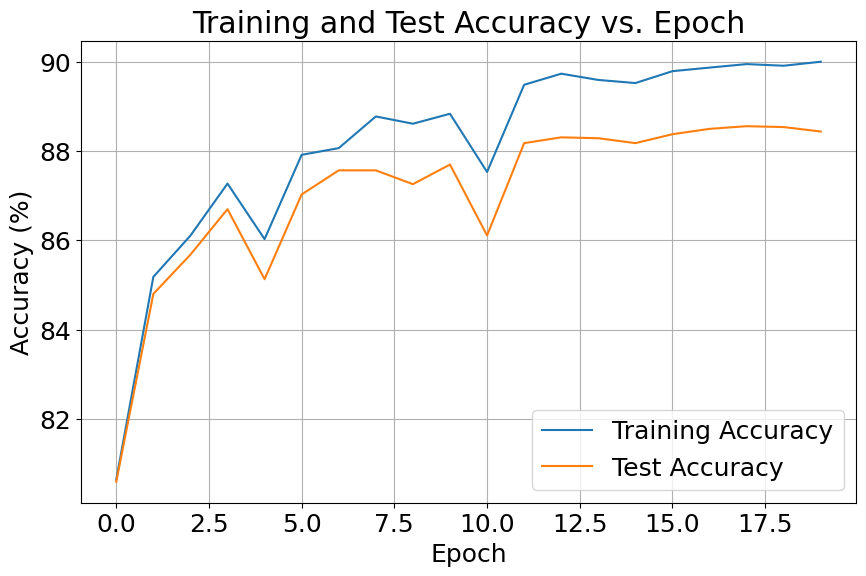

In [15]:
# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_acc, label='Training Accuracy')
plt.plot(range(epochs), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.title('Training and Test Accuracy vs. Epoch')
plt.show()

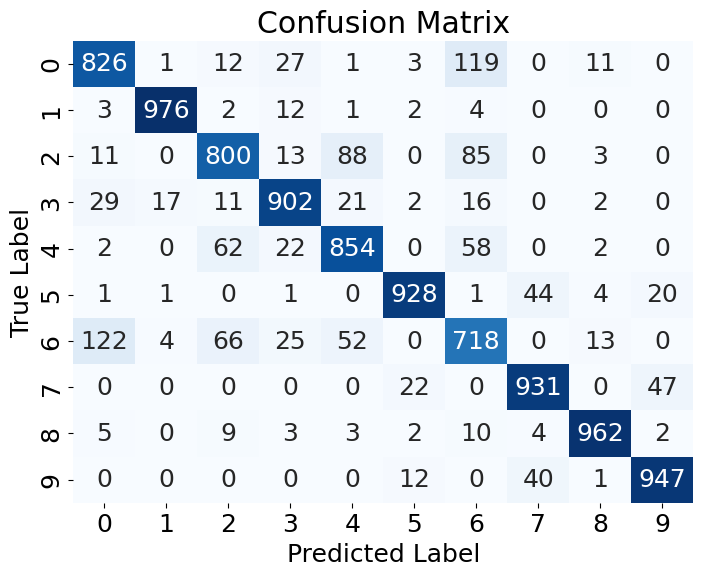

In [16]:
test_predictions: np.ndarray = np.argmax(forward(test_x, weights, biases)[0][-1], axis=1)

# Getting the actual labels
true_labels: np.ndarray = np.argmax(test_y, axis=1)

# Calculating the confusion matrix
confusion_mat: np.ndarray = confusion_matrix(true_labels, test_predictions)

# Displaying the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()